In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.polynomial.chebyshev as cheb

from matplotlib.animation import FuncAnimation
from IPython.display import HTML
plt.style.use('ggplot')

# Chebshev collocation method for simple problem

We solve the problem 

$$ \partial_t u +v \partial_x u =0$$

for $x\in [-1,1]$, with initial condition $u(x,0)=u_0(x)=\sin(\pi x)$ and boundary condition $u(-1,t)=g(t) = \sin(-\pi vt)$. This has exact solution $u(x,t)=\sin(\pi(x-vt))$.

In [ ]:
v=2.
u0=lambda x: np.sin(np.pi*x)
g=lambda t: np.sin(np.pi*(1-v*t))
ue=lambda x,t: np.sin(np.pi*(x-v*t))

We seek a solution of the form 
$$ u^{(N)} (x,t) = \sum_{k=0}^{N} \hat{u}_k(t) T_k(x)$$
where the $T_k$ are the $k$th degree Chebyshev polynomials.

### Calculating the coefficients- Chebyshev Gauss-Lobatto quadrature

To find the coefficients $\hat{u}_k$ we must perform an integration
$$ \hat{u}_k = \frac{1}{\gamma_k}(u,T_k)=\int_{-1}^1 u(x)T_k(x)w(x)dx. $$

Numerically, this is achieved via Gauss-Lobatto quadrature, in which the collocation points are at the extrema $X_j=-\cos (\frac{\pi j}{N})$, $j=0...N$ (the negative is so they are in increasing order), resulting in the expression
$$ \hat{u}_k = \frac{2}{N c_k}\sum_{j=0}^N \frac{1}{c_j} u(X_j) T_k(X_j),$$
where
$$ c_k=\begin{array}{ll}
             2 & k=0,N \\
             1 & k=1,...N-1 
            \end{array}$$

In [3]:
N=10

#Gauss-Lobatto points
X=np.zeros(N+1)
for j in range(N+1):
    X[j]=-np.cos(np.pi*j/N)

In [4]:
def findCoeffs(U, X):
    """Find the coefficients for the expansion in a basis 
    of Chebyshev polynomials up to T_N calculated  
    at the N+1 Gauss-Lobatto points
    
    Input: N+1 array U_j=u(X_j)
           N+1 array X_j Gauss-Lobatto Chebyshev points 
    
    Output: N+1- length numpy array containing coefficients uhat
    """
    N=len(X)-1
    
    c=np.ones(N+1)
    c[0]=2
    c[-1]=2
        
    uhat=np.zeros(N+1)
    
    for k in range(N+1):
        m=2./(N*c[k])
        d=np.zeros(k+1)
        d[-1]=1
        for j in range(N+1):
            uhat[k]=uhat[k]+U[j]*cheb.chebval(X[j],d)/c[j]
        uhat[k]=m*uhat[k]
    
    return uhat

In [5]:
U0=u0(X)
u0hat=findCoeffs(U0,X)

The reconstruction is exact at the Gauss-Lobatto points and is given by
$$ u_k \equiv u^{(N)}(X_k)=\sum_{i=0}^N \hat{u}_i T_i(X_k)$$

In [6]:
def recon(uhat, X):
    """ Given coefficients for the Chebyshev polynomials T_0...T_N, 
    find the value of the function at the N+1 Gauss-Lobatto points
    
    Input: N+1 array of the Chebyshev coefficients
           N+1 array X_j Gauss-Lobatto Chebyshev points 

    Output: N+1 array of the function values at the GL points
    
    """
    N=len(uhat)-1
  
    uk=np.zeros(N+1)
    for k in range(N+1):
        for i in range(N+1):
            d=np.zeros(i+1)
            d[-1]=1
            uk[k]=uk[k]+uhat[i]*cheb.chebval(X[k],d)

    return uk

Substituting the solution form into the problem definition, we get
$$  \sum_{k=0}^{N} d_t\hat{u}_k(t) T_k(x) = -v  \sum_{k=0}^{N} \hat{u}_j d_x T_k(x).$$

### Derivatives of Cheybshev polynomials

The derivatives of the Chebyshev polynomials satisfy the relations 
$$ T'_n(x)=2n(T_{n-1}(x)+T_{n-3}(x) + T_{n-5}(x)...T_1(x)) \mbox{   $n$ even} $$
$$ T'_n(x)=2n(T_{n-1}(x)+T_{n-3}(x) + T_{n-5}(x)...T_2(x))+nT_0 \mbox{   $n$ odd} $$
We can express this as
$$ T_j'(x) = \sum_{k=0}^N D_{jk} T_k(x) $$ 
where
$$ D_{jk}=
\left[ \begin{array}{ccccc}
0 & \cdots & \cdots &\cdots & 0  \\
1 & 0 & \cdots & \cdots & 0 \\
0 & 4 & 0 & \cdots & 0 \\
3 & 0 & 6 & \cdots & 0  \\
\vdots & & & \ddots & \vdots \end{array} \right]
$$

This means the derivative of our function $u$ can be written
$$  u'(x)=\sum_{j=0}^{N}\sum_{k=0}^N \hat{u}_j D_{jk} T_k(x)=\sum_{k=0}^N \tilde{u}_k T_k(x) $$ 
where $\tilde{u}_k=\sum_{j=0}^{N}\hat{u}_j D_{jk}$.

In [7]:
def chebDerivativeMatrix(N):
    D=np.zeros((N,N))
    for n in range(N):
        if n == 0:
            continue
        elif n%2==0:
            i=n-1
            while i > 0:
                D[n,i]=2*n
                i=i-2
        else:
            i=n-1
            while i>0:
                D[n,i]=2*n
                i=i-2
            D[n,0]=n
    return D

In [8]:
D=chebDerivativeMatrix(len(u0hat))

Substituting this into the problem definition, we get
$$ \partial_t \sum_{k=0}^{N} \hat{u}_k(t) T_k(x) = -v  \sum_{k=0}^{N} \sum_{j=0}^{N}\hat{u}_j D_{jk} T_k(x).$$
By evaluating these at the interior Gauss-Lobatto points, we get a system of $N+1$ ODEs for the $N+1$ coefficients $u_k$. 
$$ \frac{d}{dt}  \sum_{k=0}^{N} \hat{u}_k(t) T_k(X_i) = -v  \sum_{k=0}^{N} \sum_{j=0}^{N}\hat{u}_j D_{jk} T_k(X_i).$$

If we define $\mathbb{T}_{ik}=T_k (X_i)$, we can write this in matrix form 
$$ \mathbb{T} d_t \hat{\underline{u}} = -v \mathbb{T} D^T  \hat{\underline{u}} $$

In [9]:
def Tmatrix(X):
    N=len(X)-1
    
    T=np.zeros((N+1,N+1))
      
    for k in range(N+1):
        d=np.zeros(k+1)
        d[-1]=1
        T[k]=cheb.chebval(X,d) #T_{ki}=T_k(X_i)
    
    T=T.T #T_{ki}=T_i(X_k)
    
    return T, np.linalg.inv(T)

In this case, as $v$ is constant, we can cancel the $\mathbb{T}$ to simply get
$$  d_t \hat{\underline{u}} = -v D^T  \hat{\underline{u}} $$

We'll integrate this using a simple Euler method

In [10]:
def euler(t,u,f,h):
    u1=u+h*f(t,u)
    t1=t+h
    
    return u1,t1

In [11]:
def f(t,u):
    return -2*np.dot(D.T,u)

The boundary conditions are enfoced exactly at each time step by calculating $\underline{u}^{(N)}$ and setting $u^{(N)}_0=g(t)$.

Algorithm:

1. $t=0$
2. Calculate $\underline{\hat{u}}(t)$
3. Euler timestep to find $\underline{\hat{u}}(t+1)$, set $t=t+1$
4. Calculate $\underline{u}^{(N)}$
5. Set $u^{(N)}_0 = g(t) $
6. Return to 2


In [12]:
Tm,Tminv=Tmatrix(X)

def fgott(t,u,T=Tm,Tinv=Tminv):
    alpha=100
    
    w=np.zeros(len(u))
    w[0]=np.dot(T[0], u)-g(t) 
        
    return -2*np.dot(D.T,u)-alpha*np.dot(Tinv,w)

In [13]:

x=np.linspace(-1,1,100)

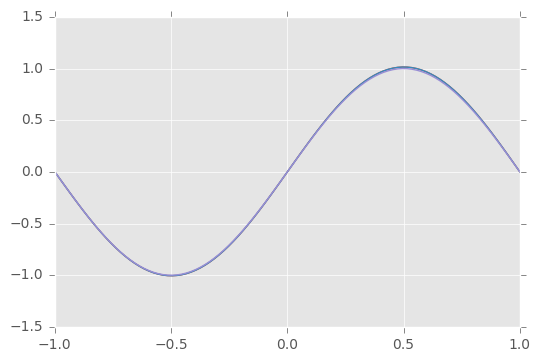

In [14]:
uhat=[u0hat]
uhat2=[u0hat]
tt=0
tt2=0
t=np.linspace(0,1,1000)
h=1./len(t)

alpha=N**2



for i in range(len(t)):
    #timestep
    u1,tt=euler(tt,uhat[i],f,h)
    #impose BC
    #reconstruct first
    u2=recon(u1,X)
    #set BC
    u2[0]=g(tt)
    u3=findCoeffs(u2,X)
    uhat.append(u3)
    #impose BC the Gottlieb way
    u12,tt2=euler(tt2,uhat2[i],fgott,h)
    uhat2.append(u12)

#reconstruct
uN=cheb.chebval(x,uhat[-1])
uN2=cheb.chebval(x,uhat2[-1])
plt.plot(x,uN)
plt.plot(x,uN2)
plt.plot(x,ue(x,t[-1]))
plt.show()